In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from scipy.interpolate import griddata
from tqdm.notebook import tqdm
from dask.diagnostics import ProgressBar

from salishsea_tools import nc_tools, geo_tools, viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Functions

In [3]:
def mtime_to_datetime(mtime):
    """Convert from Matlab time to datetime.datetime
    """
    
    return datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)


def boundingbox(data, lon, lat, lonlat, size=1, grid='NEMO', land_mask=None):
    """Return a bounding box of coordinate, value pairs around a lonlat point
    """

    j, i = find_closest_model_point(lon, lat, *lonlat, grid=grid, land_mask=land_mask)
    if np.logical_or(j is None, i is None):
        return None, None
    jslc, islc = [slice(coord - size, coord + size + 1) for coord in (j, i)]
    points = np.vstack([coord[jslc, islc].flatten() for coord in lonlat]).T
    if grid == 'NEMO':
        values = data.isel(y=jslc, x=islc)
    elif grid == 'GEM2.5':
        values = data.isel(gridY=jslc, gridX=islc)
    
    return points, values


def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.007, 'tol_lat': 0.004},
        'GEM2.5': {'tol_lon': 0.018, 'tol_lat': 0.013},
    },
):
    """Wrapper for geo_tools.find_closest_model_point but with
    flexible tolerances.
    """
    
    # Find closest model point
    try:
        j, i = geo_tools.find_closest_model_point(
            lon, lat, model_lons, model_lats,
            grid=grid, land_mask=land_mask, tols=tols,
        )
    except ValueError:
        j, i = None, None

    return j, i

***

### Processing parameters

In [4]:
# Definitions
dateorigin = datetime(2000, 1, 1)
ysub, xsub = slice(70, 210), slice(90, 170)
chunks_generic = {'time_counter': 24, 'y': 898, 'x': 398}
drop_vars = [
    'axis_nbounds', 'nvertex', 'nav_lat', 'nav_lon', 'area',
    'bounds_lon', 'bounds_lat', 'depthu_bounds', 'depthv_bounds',
    'time_centered', 'time_centered_bounds', 'time_counter_bounds',
]

# Paths and filenames
paths = {
    'grid': '/data/bmoorema/MEOPAR/grid/',
    'erddap': 'https://salishsea.eos.ubc.ca/erddap/griddap/',
    'drifters': '/ocean/shared/drifters/data/L3/',
}
filenames = {
    'coords_NEMO': paths['grid'] + 'coordinates_seagrid_SalishSea201702.nc',
    'coords_HRDPS': paths['erddap'] + 'ubcSSaAtmosphereGridV1',
    'data_HRDPS': paths['erddap'] + 'ubcSSaSurfaceAtmosphereFieldsV1',
    'drifters': paths['drifters'] + 'Salish_L3_20190728T103529.mat',
    'mask_NEMO': paths['grid'] + 'mesh_mask201702.nc',
}

# Load HRDPS and NEMO coordinate grids
coords_HRDPS = xr.open_dataset(filenames['coords_HRDPS']).isel(gridY=ysub, gridX=xsub)
coords_NEMO = xr.open_dataset(filenames['coords_NEMO'], decode_times=False)
mask_NEMO = xr.open_dataset(filenames['mask_NEMO'])
lonlat, mask = {'NEMO': {}}, {}
lonlat['HRDPS'] = [coords_HRDPS[key].values - corr for key, corr in zip(['longitude', 'latitude'], [360, 0])]
for var in ['u', 'v']:
    lonlat['NEMO'][var] = [coords_NEMO[key][0, ...].values for key in (f'glam{var}', f'gphi{var}')]
    mask[var] = mask_NEMO[f'{var}mask'][0, 0, ...].values
    
# Assign HRDPS data object
data_HRDPS = xr.open_dataset(
    filenames['data_HRDPS'],
    drop_variables=['atmpres', 'precip', 'qair', 'solar', 'tair', 'therm_rad'],
).isel(gridY=ysub, gridX=xsub)

# Load drifters
drifters = loadmat(filenames['drifters'])['drift'][0]
IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if drifters['lon'][dindex][0] < -124.5: IDout.append(ID)
IDout = list(np.unique(IDout))
for ID in IDout: IDs.remove(ID)

***

### Process data

In [5]:
times = []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    times.append(np.array([mtime_to_datetime(int(t)) for t in drifters['mtime'][dindex][:, 0]]))

prefixes = [nc_tools.get_hindcast_prefix(date) for date in np.unique(np.hstack(times))]
NEMO = {}
for var, name in zip(['u', 'v'], ['vozocrtx', 'vomecrty']):
    files = [f'{prefix}_grid_{var.upper()}.nc' for prefix in prefixes]
    chunks, slc = dict(chunks_generic, **{f'depth{var}': 2}), {f'depth{var}': slice(None, 2)}
    with ProgressBar():
        with xr.open_mfdataset(files, chunks=chunks, drop_variables=drop_vars) as ds:
            NEMO[var] = ds[name].isel(slc).load(scheduler="processes", num_workers=8)

[########################################] | 100% Completed |  8min 57.6s
[########################################] | 100% Completed | 15min 34.9s


In [ ]:
fn = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCastV201905_1h_drifters_grid_UV.nc'
xr.Dataset({var: NEMO[var].isel({f'depth{var}': 0}).drop_vars(f'depth{var}') for var in ['u', 'v']}).to_netcdf(fn)

In [ ]:
ndrifters, depths, method = 100, [0, 0.25, 0.5], 'linear'

# Initialize lists
data = {}
for key in ['time', 'lon', 'lat', 'u_obs', 'v_obs', 'u_HRDPS', 'v_HRDPS']: data[key] = []
for key in ['u_NEMO', 'v_NEMO']: data[key] = {depth: [] for depth in depths}

# Loop through drifters
for n, ID in zip(tqdm(range(ndrifters)), IDs):

    # Load drifters
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    times = np.array([mtime_to_datetime(t) for t in drifters['mtime'][dindex][:, 0]])
    lons, lats = [drifters[key][dindex][:, 0] for key in ('lon', 'lat')]
    dt = np.array([t.total_seconds() for t in np.diff(times)])
    uv = []
    for coord, theta in zip([lons, lats], [0, np.deg2rad(lats[:-1])]):
        uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
    u, v = viz_tools.rotate_vel(*uv, origin='map')
    times, lons, lats = times[:-1], lons[:-1], lats[:-1]
    for key, val in zip(['time', 'lon', 'lat', 'u_obs', 'v_obs'], [times, lons, lats, u, v]):
        data[key].append(val)

    # Load HRDPS and NEMO
    start, end = [t+timedelta(days=d) for t, d in zip(np.unique([t.date() for t in times])[[0, -1]], [-1, 1])]
    HRDPS = data_HRDPS.sel(time=slice(start, end)).load()
    prefixes = [nc_tools.get_hindcast_prefix(start+timedelta(days=d)) for d in range((end-start).days+1)]
    NEMO = {}
    for var, name in zip(['u', 'v'], ['vozocrtx', 'vomecrty']):
        files = [f'{prefix}_grid_{var.upper()}.nc' for prefix in prefixes]
        chunks, slc = dict(chunks_generic, **{f'depth{var}': 2}), {f'depth{var}': slice(None, 2)}
        with xr.open_mfdataset(files, chunks=chunks, drop_variables=drop_vars) as ds:
            NEMO[var] = ds[name].isel(slc).load(scheduler="processes", num_workers=8)

    # Interpolate velocities
    for time, lon, lat in zip(times, lons, lats):
        
        # HRDPS
        points, values = boundingbox(HRDPS, lon, lat, lonlat['HRDPS'], grid='GEM2.5')
        if np.logical_or(points is None, values is None):
            for key in ['u', 'v']: data[f'{key}_HRDPS'].append(np.nan)
        else:
            values = values.interp(time=time, method=method)
            uv = []
            for var in ['u', 'v']:
                uv.append(griddata(points, values[f'{var}_wind'].values.flatten(), (lon, lat), method=method))
            u, v = viz_tools.rotate_vel(*uv, origin='map')
            for key, val in zip(['u', 'v'], [u, v]): data[f'{key}_HRDPS'].append(val)
        
        # NEMO
        for var in ['u', 'v']:
            points, values = boundingbox(NEMO[var], lon, lat, lonlat['NEMO'][var], land_mask=mask[var]==0)
            for depth in depths:
                if np.logical_or(points is None, values is None):
                    data[f'{var}_NEMO'][depth].append(np.nan)
                else:
                    args, kwargs = {'time_counter': time, f'depth{var}': depth}, {'fill_value': 'extrapolate'}
                    data[f'{var}_NEMO'][depth].append(
                        griddata(points, values.interp(args, method=method, kwargs=kwargs).values.flatten(), (lon, lat), method=method),
                    )

# Concatenate
for key in ['time', 'lon', 'lat', 'u_obs', 'v_obs', 'u_HRDPS', 'v_HRDPS']: data[key] = np.hstack(data[key])
for key in ['u_NEMO', 'v_NEMO']:
    for depth in depths: data[key][depth] = np.hstack(data[key][depth])

***

### Plot results

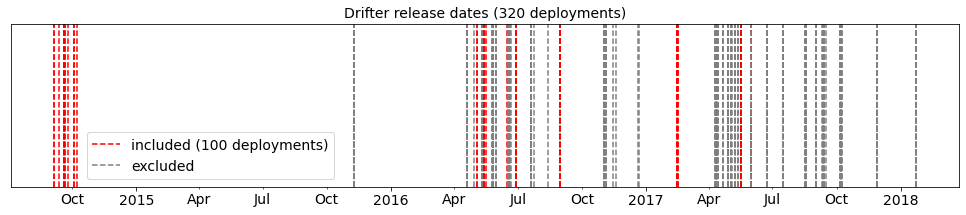

In [173]:
# Plot drifter release dates
fig, ax = plt.subplots(figsize=(17, 3))
for slc, string, color in zip([(None, ndrifters), (ndrifters, None)], [f'included ({ndrifters} deployments)', 'excluded'], ['r', 'gray']):
    for n, ID in enumerate(IDs[slice(*slc)]):
        label = string if n == 0 else None 
        dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
        times = np.array([mtime_to_datetime(t) for t in drifters['mtime'][dindex][:, 0]])
        ax.plot([times[0], times[0]], [0, 1], '--', color=color, label=label)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=3))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.set_ylim(0, 1)
ax.yaxis.set_ticks([])
ax.set_title(f'Drifter release dates ({len(IDs)} deployments)', size=14)
ax.legend(loc=[0.08, 0.05])
plt.show()

***

### Effect of depth interpolation

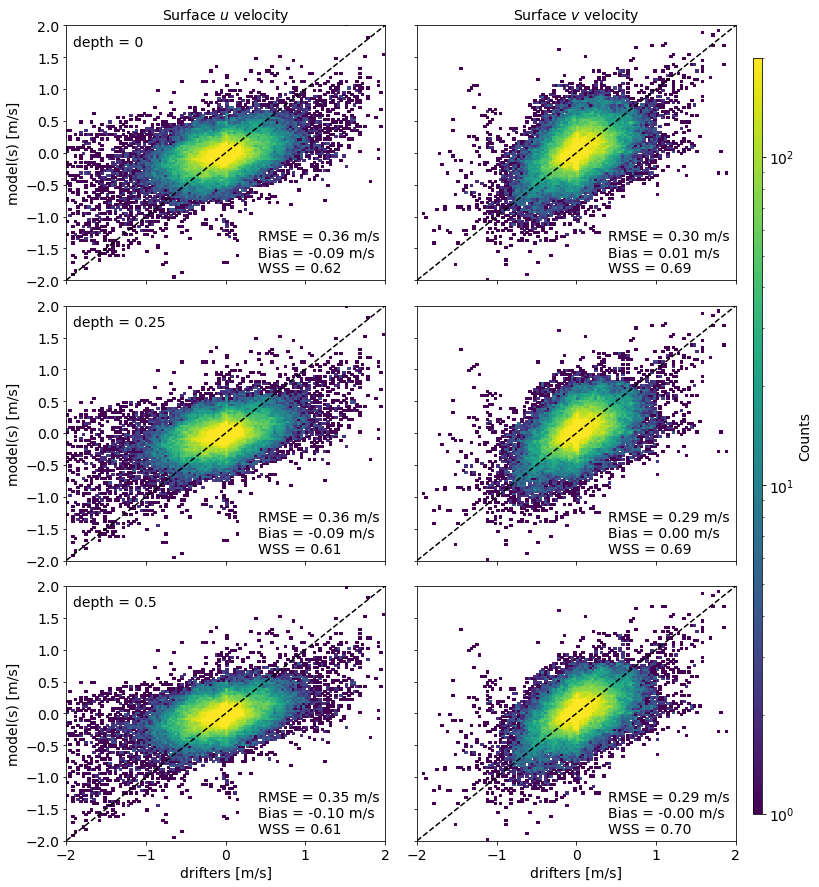

In [133]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
for row, depth in zip(axs, [0, 0.25, 0.5]):
    for ax, var in zip(row, ['u', 'v']):

        # Make nan index
        index = np.logical_and(
            np.logical_and(np.isfinite(data[f'{var}_obs']), np.isfinite(data[f'{var}_NEMO'][depth])),
            ~np.logical_or(np.isnan(data[f'{var}_obs']), np.isnan(data[f'{var}_NEMO'][depth])),
        )

        # Calc stats
        x, y = data[f'{var}_obs'][index], data[f'{var}_NEMO'][depth][index]
        MSE = np.mean((y - x)**2)
        RMSE = np.sqrt(MSE)
        bias = np.mean(abs(y)) - np.mean(abs(x))
        WSS = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)

        # Plot data and stats
        _, _, _, c = ax.hist2d(x, y, bins=300, range=[(-5, 5), (-5, 5)], norm=colors.LogNorm(vmin=1, vmax=200))
        ax.plot([-2, 2], [-2, 2], 'k--')
        ax.text(0.6, 0.03, f'RMSE = {RMSE:.2f} m/s\nBias = {bias:.2f} m/s\nWSS = {WSS:.2f}', transform=ax.transAxes)

        # Formating
        ax.set_xlim([-2, 2])
        ax.set_ylim([-2, 2])
        if depth == 0: ax.set_title(f'Surface ${var}$ velocity', size=14)
        if depth == 0.5: ax.set_xlabel(f'drifters [m/s]')
        else: ax.xaxis.set_ticklabels('')
        if var == 'u':
            ax.text(0.02, 0.92, f'depth = {depth}', transform=ax.transAxes)
            ax.set_ylabel(f'model(s) [m/s]')
        else: ax.yaxis.set_ticklabels('')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Counts')

plt.show()

***

### Effect of wind drift

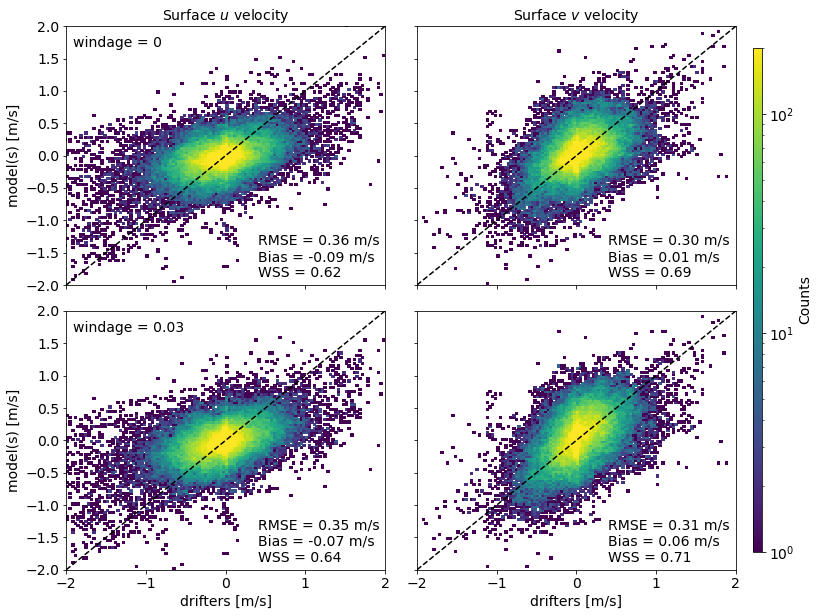

In [138]:
depth = 0

fig, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
for row, windage in zip(axs, [0, 0.03]):
    for ax, var in zip(row, ['u', 'v']):

        # Make nan index
        index = np.logical_and(
            np.logical_and(np.logical_and(*[np.isfinite(data[f'{var}_{key}']) for key in ('obs', 'HRDPS')]), np.isfinite(data[f'{var}_NEMO'][depth])),
            ~np.logical_or(np.logical_or(*[np.isnan(data[f'{var}_{key}']) for key in ('obs', 'HRDPS')]), np.isnan(data[f'{var}_NEMO'][depth])),
        )

        # Calc stats
        x, y = data[f'{var}_obs'][index], data[f'{var}_NEMO'][depth][index] + windage * data[f'{var}_HRDPS'][index]
        MSE = np.mean((y - x)**2)
        RMSE = np.sqrt(MSE)
        bias = np.mean(abs(y)) - np.mean(abs(x))
        WSS = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)

        # Plot data and stats
        _, _, _, c = ax.hist2d(x, y, bins=300, range=[(-5, 5), (-5, 5)], norm=colors.LogNorm(vmin=1, vmax=200))
        ax.plot([-2, 2], [-2, 2], 'k--')
        ax.text(0.6, 0.03, f'RMSE = {RMSE:.2f} m/s\nBias = {bias:.2f} m/s\nWSS = {WSS:.2f}', transform=ax.transAxes)

        # Formating
        ax.set_xlim([-2, 2])
        ax.set_ylim([-2, 2])
        if windage == 0:
            ax.set_title(f'Surface ${var}$ velocity', size=14)
            ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel(f'drifters [m/s]')
        if var == 'u':
            ax.text(0.02, 0.92, f'windage = {windage}', transform=ax.transAxes)
            ax.set_ylabel(f'model(s) [m/s]')
        else: ax.yaxis.set_ticklabels('')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Counts')

plt.show()